In [1]:
import jax.numpy as jnp
import jax
import jax.random as jr

from optimizers.gd import SGDState, sgd_step


from optimizers.mrcg import MRCGState, mrcg_step

import matplotlib.pyplot as plt
from model_zoo import rosenbrock_loss, beale_loss

## Model Definition

In [2]:
initial_params = jnp.array([1.0, 2.0, 3.0])

def model(params, x):
    return x[:, 0] **2 * params[0] + x[:, 1] * params[1] + x[:, 2] * params[2]

def loss(y_pred, y_true):
    return jnp.mean((y_pred - y_true) ** 2)
x = jnp.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
y_true = jnp.array([[1.0], [2.0]])

def loss_at_params(params, key=None):
    y_pred = model(params, x)
    return loss(y_pred, y_true)


In [3]:
def harder_model(params, x):
    return (
        jnp.sin(x[:, 0] * params[0]) +
        jnp.exp(-x[:, 1] * params[1]) +
        (x[:, 2] ** 2) * params[2] * jnp.sin(params[2])
    )

x = jnp.array([
        [1.0, 2.0, 3.0],
        [1.0, 5.0, -2.0],
        [0.0, 14.0, 3.0],
        [3.0, 2.0, 8.0]
        ])

## Optimizers Comparison

In [4]:
def iterate_alg(max_iters, initial_state, step_fn, verbose=False) -> list:
    losses = []
    state = initial_state
    for i in range(max_iters):
        loss = state.loss_at_params(state.params)
        losses.append(loss)

        state = step_fn(state)
        if verbose:
            print(f"Iteration {i}: Loss = {loss} Params = {state.params}")
    return losses

Iteration 0: Loss = 14379.93359375 Params = [7.56675   1.7054996]
Iteration 1: Loss = 2023.30810546875 Params = [5.6200523  0.11218679]
Iteration 2: Loss = 640.803466796875 Params = [ 4.4676557  -0.23218861]
Iteration 3: Loss = 340.7772216796875 Params = [ 3.6387534 -0.2608936]
Iteration 4: Loss = 214.75054931640625 Params = [ 2.988881   -0.21748346]
Iteration 5: Loss = 142.0692138671875 Params = [ 2.4632218  -0.16416897]
Iteration 6: Loss = 95.42294311523438 Params = [ 2.0335746  -0.11572078]
Iteration 7: Loss = 64.45588684082031 Params = [ 1.6812094  -0.07469674]
Iteration 8: Loss = 43.676544189453125 Params = [ 1.3919091  -0.04067439]
Iteration 9: Loss = 29.686542510986328 Params = [ 1.1543032  -0.01264157]
Iteration 10: Loss = 20.25835418701172 Params = [0.95913243 0.01040839]
Iteration 11: Loss = 13.903212547302246 Params = [0.7988124  0.02934868]
Iteration 12: Loss = 9.619842529296875 Params = [0.6671184  0.04490871]
Iteration 13: Loss = 6.733431816101074 Params = [0.5589387 0.05

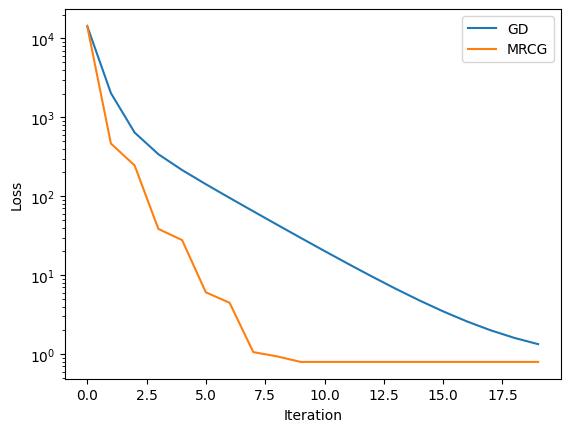

In [5]:
def plot_alg_comparison(ro, initial_params, max_iters=20):
    key = jr.PRNGKey(0)
    sgd_losses = iterate_alg(
        max_iters,
        SGDState(
            initial_params,
            loss_at_params,
            0.005,
            key,
        ),
        sgd_step,
        verbose=True
    )


    mrcg_losses = iterate_alg(
        max_iters,
        MRCGState(initial_params, loss_at_params, key),
        mrcg_step,
        verbose=True
    )
    plt.plot(sgd_losses, label='GD')
    plt.plot(mrcg_losses, label='MRCG')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')

plot_alg_comparison(rosenbrock_loss, jnp.array([12, 8.1]), max_iters=20)

Iteration 0: Loss = 14379.93359375 Params = [7.56675   1.7054996]
Iteration 1: Loss = 2023.30810546875 Params = [5.6200523  0.11218679]
Iteration 2: Loss = 640.803466796875 Params = [ 4.4676557  -0.23218861]
Iteration 3: Loss = 340.7772216796875 Params = [ 3.6387534 -0.2608936]
Iteration 4: Loss = 214.75054931640625 Params = [ 2.988881   -0.21748346]
Iteration 5: Loss = 142.0692138671875 Params = [ 2.4632218  -0.16416897]
Iteration 6: Loss = 95.42294311523438 Params = [ 2.0335746  -0.11572078]
Iteration 7: Loss = 64.45588684082031 Params = [ 1.6812094  -0.07469674]
Iteration 8: Loss = 43.676544189453125 Params = [ 1.3919091  -0.04067439]
Iteration 9: Loss = 29.686542510986328 Params = [ 1.1543032  -0.01264157]
Iteration 10: Loss = 20.25835418701172 Params = [0.95913243 0.01040839]
Iteration 11: Loss = 13.903212547302246 Params = [0.7988124  0.02934868]
Iteration 12: Loss = 9.619842529296875 Params = [0.6671184  0.04490871]
Iteration 13: Loss = 6.733431816101074 Params = [0.5589387 0.05

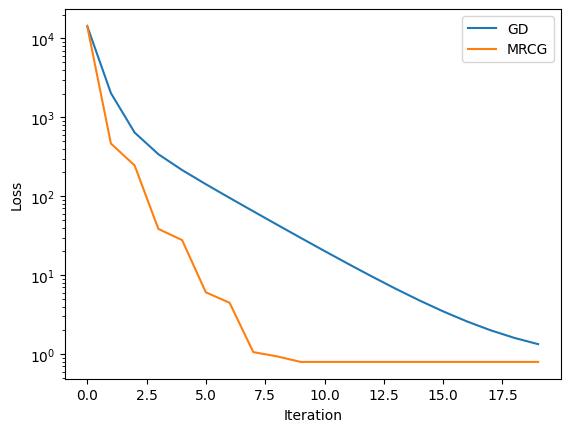

In [6]:
plot_alg_comparison(beale_loss, jnp.array([12, 8.1]), max_iters=20)

In [7]:
from jax_examples import datasets
mnist = datasets.mnist()

In [8]:
len(mnist)

4

## Stochastic

In [9]:
def make_stochastic_mse_loss(x_data: jnp.ndarray, y_data: jnp.ndarray, batch_size: int):
    """
    Returns a loss function that computes MSE on a random mini-batch.
    
    Args:
        x_data: shape (N, D)
        y_data: shape (N,)
        batch_size: int

    Returns:
        loss_fn(params, key): stochastic loss function
    """
    N = x_data.shape[0]

    def loss_fn(params: jnp.ndarray, key: jax.random.PRNGKey) -> jnp.ndarray:
        idx = jax.random.choice(key, N, shape=(batch_size,), replace=False)
        x_batch = x_data[idx]
        y_batch = y_data[idx]

        preds = x_batch @ params
        return jnp.mean((preds - y_batch) ** 2)

    return loss_fn


Iteration 0: Loss = 2.5 Params = [0.04125 0.08625 0.045   0.      0.      0.      0.      0.      0.
 0.     ]
Iteration 1: Loss = 0.9886258840560913 Params = [0.0603375  0.11446875 0.06115312 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 2: Loss = 0.793366551399231 Params = [0.07075273 0.12315863 0.06654032 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 3: Loss = 0.7624053955078125 Params = [0.07748051 0.12549533 0.06769536 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 4: Loss = 0.7538274526596069 Params = [0.08245544 0.12591785 0.06705879 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 5: Loss = 0.7491965889930725 Params = [0.08648784 0.12587348 0.06559412 0.         0.         0.
 0.         0.         0.         0.        ]
Iteration 6: Loss = 0.7456827163696289 Params = [0.0899536  0.1258002  0.06371444 0.         0.         0.
 0.         0.    

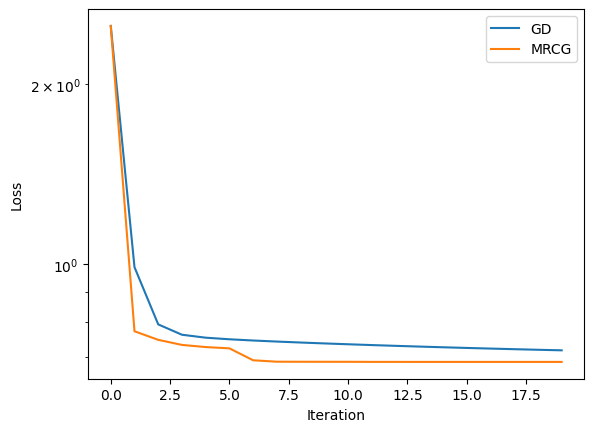

In [10]:
# Generate synthetic data
import jax.random as jr


key = jr.PRNGKey(0)
N, D = 1000, 10
x_data = jr.normal(key, (N, D))
true_w = jnp.arange(1, D + 1)
y_data = x_data @ true_w + 0.1 * jr.normal(key, (N,))

# Create loss function
batch_size = 32
loss_fn = make_stochastic_mse_loss(x_data, y_data, batch_size)

# Initialize parameters and SGD state
init_params = jnp.zeros(D)
plot_alg_comparison(
    loss_fn,
    init_params,
    max_iters=20
)

## Mnist

In [11]:
from models.mnist import loss_at_params, train_accuracy, test_accuracy, init_random_params
%reload_ext autoreload
%autoreload 2

print(f"Train accuracy: {train_accuracy(init_params):.2f}")
print(f"Validation accuracy: {test_accuracy(init_params):.2f}")
losses = iterate_alg(
    20,
    SGDState(
        init_params,
        loss_at_params,
        0.005,
        key,
    ),
    sgd_step,
    verbose=True
)

train_images.shape (60000, 784)
train_labels.shape (60000, 10)
test_images.shape (10000, 784)
test_labels.shape (10000, 10)


TypeError: iteration over a 0-d array